# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prince

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings("ignore")

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [105]:
data = pd.read_csv('https://github.com/kurniawanchandraw/Supervised_and_Unsupervised_Project/raw/refs/heads/main/Dataset_clustering.csv')
data.head()

,Unnamed: 0,TransactionAmount,TransactionAmountRelativeToBalance,AccountBalance,LoginAttempts,CustomerOccupation,FAMD_1,FAMD_2,KMeans_Cluster,GMM_Cluster,Agglomerative_Cluster
0,0,-0.855820,-0.334233,-0.888266,-0.206794,Doctor,-0.230694,-0.458759,0,1,0
1,1,-0.289919,-0.291284,-0.239452,-0.206794,Doctor,-0.222465,-0.323291,0,1,0
2,2,0.614606,0.416503,-1.015296,-0.206794,Student,1.096156,-0.151834,0,1,0
3,3,-0.816319,-0.370676,0.163220,-0.206794,Student,-0.802282,-0.211974,0,1,0
4,4,-0.976312,-0.386991,0.334900,-0.206794,Student,-0.981635,-0.211928,0,1,0


In [106]:
data.set_index('Unnamed: 0', inplace=True)
data.rename(columns={'GMM_Cluster': 'Cluster'}, inplace=True)

Mengambil kolom reduksi dimensi, yaitu `FAMD_1` dan `FAMD_2`.

In [107]:
data = data[['FAMD_1', 'FAMD_2', 'Cluster']]

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2511 entries, 0 to 2511
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   FAMD_1   2511 non-null   float64
 1   FAMD_2   2511 non-null   float64
 2   Cluster  2511 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 78.5 KB


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [109]:
X = data.drop(columns=['Cluster'])
y = data['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
oversample = TomekLinks()
model_pipeline = ImbPipeline(steps=[
    ('sampling', oversample),
    ('classifier', RandomForestClassifier(random_state=42))
])

# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

In [119]:
param_grid = {
    # Optimasi teknik untuk menangani class imbalance
    'sampling': [SMOTE(random_state=42), TomekLinks()],
    
    # Mencari model terbaik
    'classifier': [
        RandomForestClassifier(random_state=42),
        SVC(random_state=42),
        LogisticRegression(random_state=42),
        KNeighborsClassifier(),
        GaussianNB(),
        DecisionTreeClassifier(random_state=42)
    ]
}

In [120]:
# GridSearchCV untuk mencari kombinasi parameter terbaik
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-Score: {grid_search.best_score_}")

Best parameters: {'classifier': KNeighborsClassifier(), 'sampling': SMOTE(random_state=42)}
Best cross-validation F1-Score: 1.0


Pipeline menggabungkan seluruh proses dari preprocessing hingga model training dalam satu urutan:
1. Imbalance Sampling (misal SMOTE) untuk mengatasi imbalance data.
2. Model (misal SVC) dilatih setelah data diproses.
3. Evaluasi menggunakan F1-Score Macro untuk menilai kinerja model.

GridSearchCV mengoptimalkan seluruh pipeline, mencari kombinasi terbaik model dan imbalance handling untuk mendapatkan performa terbaik (berdasarkan F1-Score). Pencarian ini dilakukan di seluruh ruang parameter yang ditentukan. Didapatkan model terbaik berdasarkan GridSearchCV adlaah model $k$-Nearest Neighbor dengan *macro* $F_1$-*score* yang sempurna. Hal ini mengindikasikan adanya *overfitting* secara konteks data. *Overfitting* ini sangat mungkin untuk terjadi karena fitur-fitur yang digunakan dalam pembentukan klaster adalah `FAMD_1` dan `FAMD_2` itu sendiri.

## **b. Evaluasi Model Klasifikasi**

In [116]:
# Evaluasi pada data test
y_pred_best = grid_search.best_estimator_.predict(X_test)

# Metrik Evaluasi: F1-Score
f1_best = f1_score(y_test, y_pred_best, average='macro')
# Metrik Evaluasi: Akurasi
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Best F1 Score on Test Data: {f1_best:.4f}')
print(f'Best Accuracy on Test Data: {accuracy_best:.4f}')

Best F1 Score on Test Data: 1.0000
Best Accuracy on Test Data: 1.0000


In [117]:
# Get classification report
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00       477

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



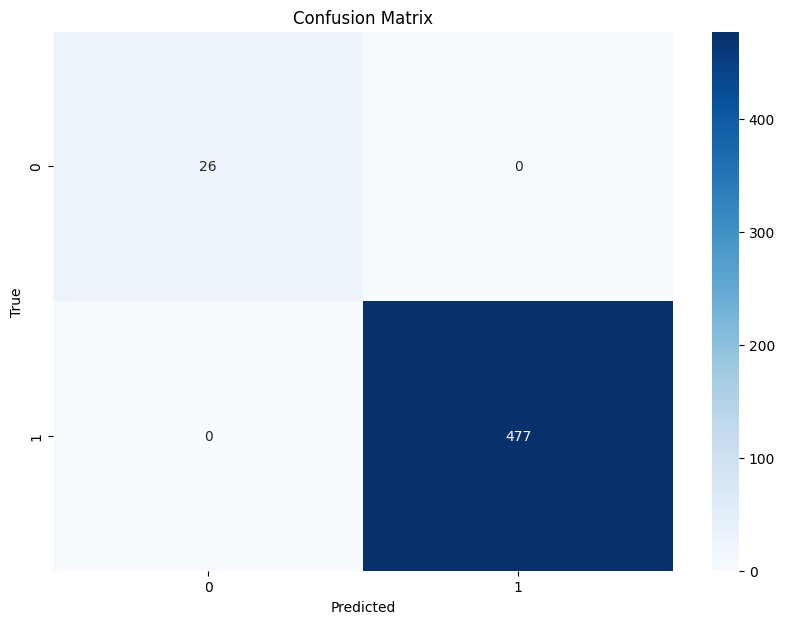

In [118]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

Model $k$-Nearest Neighbor memberikan prediksi yang sempurna pada data latih. Confusion matrix di atas menunjukkan hasil prediksi model pada data uji, di mana terdapat dua kelas: kelas 0 dan kelas 1. Berdasarkan matriks tersebut:

- True Negatives (TN): 26, yang berarti ada 26 sampel yang sebenarnya termasuk kelas 0, dan model memprediksinya dengan benar sebagai kelas 0.
- False Positives (FP): 0, yang berarti tidak ada sampel kelas 0 yang diprediksi sebagai kelas 1.
- False Negatives (FN): 0, yang berarti tidak ada sampel kelas 1 yang diprediksi sebagai kelas 0.
- True Positives (TP): 477, yang berarti ada 477 sampel kelas 1 yang diprediksi dengan benar sebagai kelas 1

Selanjutnya, akan dibandingkan hasilnya dengan model lain di luar pipeline scikit-learn, yaitu XGBoost dan CatBoost:

**Model XGBoost:**

In [121]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train) 

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_resampled, y_resampled)

y_pred2 = xgb_model.predict(X_test)
report_xgb = classification_report(y_test, y_pred2, output_dict=True)
report_xgb

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 26.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 477.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 503.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 503.0}}

**CatBoost**

In [122]:
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model.fit(X_resampled, y_resampled)

y_pred2 = catboost_model.predict(X_test)

report_catboost = classification_report(y_test, y_pred2, output_dict=True)
report_catboost

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 26.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 477.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 503.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 503.0}}

Perbandingan Model:

In [123]:
df_results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'CatBoost'],
    'Accuracy': [accuracy_best, report_xgb['accuracy'], report_catboost['accuracy']],
    'F1 Score': [f1_best, report_xgb['macro avg']['f1-score'], report_catboost['macro avg']['f1-score']]
})
df_results.sort_values(by='F1 Score', ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results

,Model,Accuracy,F1 Score
0,Random Forest,1.0,1.0
1,XGBoost,1.0,1.0
2,CatBoost,1.0,1.0


Ketiga model menghasilkan akurasi yang sempurna.

## **c. Tuning Model Klasifikasi (Opsional)**

Model sudah menunjukkan performa yang sempurna sehingga tidak akan dilakukan *hyperparameter tuning*.

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Konsisten dengan poin (c).

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Perbandingan Hasil Evaluasi Sebelum dan Setelah Tuning:
1. Dengan menggunakan GridSearchCV, berhasil dioptimalkan proses pembentukan model dan teknik penanganan class imbalance seperti SMOTE. Model terbaik berdasarkan F1-Score adalah K-Nearest Neighbor (KNN) dengan hasil yang sempurna di data latih dan data uji.
2. F1-Score dan Akurasi pada data latih dan data uji menunjukkan 1.0 yang berarti model ini sangat baik dalam menangani dataset ini tanpa adanya kesalahan prediksi.

Identifikasi Kelemahan Model:
1. Model Perfect Performance: Dalam hal ini, terlihat adanya performa sempurna pada data latih dan data uji, yang bisa menunjukkan bahwa model overfit terhadap dataset ini. F1-Score dan Akurasi yang 1.0 pada kedua dataset bisa berarti bahwa model terlalu spesifik pada data yang ada dan mungkin tidak akan bekerja dengan baik pada data lain yang lebih beragam.

Rekomendasi Tindakan Lanjutan:
1. Validasi pada Data Baru: Meskipun model sudah sempurna pada data latih dan uji, penting untuk menguji model ini dengan data eksternal atau data baru yang lebih beragam untuk memastikan bahwa model tidak hanya menghafal pola yang ada dalam data latih. Hal ini bisa dilakukan dengan mengumpulkan lebih banyak data.
2. Peningkatan Data Variasi: Untuk memastikan model dapat generalize dengan baik, tambahkan variasi dalam dataset dengan menggunakan data yang lebih bervariasi atau mengubah fitur-fitur dalam dataset untuk menciptakan tantangan yang lebih besar bagi model, agar model tidak hanya bekerja dengan baik pada data yang mirip dengan data latih.
3. Penggunaan variabel asal atau non-reduksi: Untuk menangkap hubungan kompleks antarvariabel dengan cluster tanpa melalui reduksi dimensi.